<a href="https://colab.research.google.com/github/mohanrajmit/DL-Training/blob/master/expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

%matplotlib inline

In [2]:
# prompt: kaggle dataset download code with kaalge token API

!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"mohanraj4072","key":"ee3b7c0d72cd803ae446aaf438ef5258"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset


 98% 118M/121M [00:03<00:00, 42.5MB/s]
100% 121M/121M [00:03<00:00, 39.6MB/s]


In [4]:
!unzip /content/face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [5]:
from imutils import paths
import cv2

In [7]:
imagePaths = list(paths.list_images("/content/images/train"))
print(imagePaths)

['/content/images/train/happy/9125.jpg', '/content/images/train/happy/22790.jpg', '/content/images/train/happy/722.jpg', '/content/images/train/happy/17229.jpg', '/content/images/train/happy/10690.jpg', '/content/images/train/happy/3202.jpg', '/content/images/train/happy/28494.jpg', '/content/images/train/happy/9298.jpg', '/content/images/train/happy/24657.jpg', '/content/images/train/happy/1187.jpg', '/content/images/train/happy/15159.jpg', '/content/images/train/happy/31359.jpg', '/content/images/train/happy/24298.jpg', '/content/images/train/happy/17652.jpg', '/content/images/train/happy/33469.jpg', '/content/images/train/happy/30688.jpg', '/content/images/train/happy/17948.jpg', '/content/images/train/happy/15264.jpg', '/content/images/train/happy/11127.jpg', '/content/images/train/happy/28160.jpg', '/content/images/train/happy/26308.jpg', '/content/images/train/happy/5522.jpg', '/content/images/train/happy/24418.jpg', '/content/images/train/happy/24440.jpg', '/content/images/train

In [8]:
print(len(imagePaths))

28821


In [9]:
test_imagePaths = list(paths.list_images("/content/images/validation"))
print(test_imagePaths)

['/content/images/validation/happy/4910.jpg', '/content/images/validation/happy/10456.jpg', '/content/images/validation/happy/898.jpg', '/content/images/validation/happy/6500.jpg', '/content/images/validation/happy/34965.jpg', '/content/images/validation/happy/7753.jpg', '/content/images/validation/happy/370.jpg', '/content/images/validation/happy/34720.jpg', '/content/images/validation/happy/19548.jpg', '/content/images/validation/happy/17194.jpg', '/content/images/validation/happy/35707.jpg', '/content/images/validation/happy/16562.jpg', '/content/images/validation/happy/33091.jpg', '/content/images/validation/happy/11614.jpg', '/content/images/validation/happy/3069.jpg', '/content/images/validation/happy/21439.jpg', '/content/images/validation/happy/28954.jpg', '/content/images/validation/happy/3250.jpg', '/content/images/validation/happy/31029.jpg', '/content/images/validation/happy/19700.jpg', '/content/images/validation/happy/11842.jpg', '/content/images/validation/happy/7659.jpg

In [10]:
print(len(test_imagePaths))

7066


In [11]:
def load(imagePaths):
  # initialize the list of features and labels
  data = []
  labels = []

  # loop over the input images
  for (i, imagePath) in enumerate(imagePaths):
    # load the image and extract the class label assuming
    # that our path has the following format:
    # /path/to/dataset/{class}/{image}.jpg
    image = cv2.imread(imagePath,0)
    label = imagePath.split("/")[-2]
    labels.append(label)
    #label = imagePath.split(os.path.sep)[-2]
    image = cv2.resize(image, (48, 48),interpolation=cv2.INTER_AREA)

    # treat our processed image as a "feature vector"
    # by updating the data list followed by the labels
    data.append(image)
    #labels.append(label)

    # show an update every `verbose` images
    #if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
    #print("[INFO] processed {}/{}".format(i + 1,
    #len(imagePaths)))

    # return a tuple of the data and labels
  return (np.array(data), np.array(labels))

In [12]:
print(len(imagePaths))

28821


In [13]:
(data, labels) = load(imagePaths)

In [14]:
data.shape

(28821, 48, 48)

In [15]:
(test_data, test_labels) = load(test_imagePaths)

In [16]:
print(test_data.shape)

(7066, 48, 48)


In [17]:
print(data.shape)

(28821, 48, 48)


In [18]:
print(labels.shape)

(28821,)


In [19]:
print(labels[0])

happy


In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
le = LabelEncoder()
le_labels = le.fit_transform(labels)

In [22]:
le.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype='<U8')

In [23]:
test_le_labels = le.fit_transform(test_labels)

In [24]:
le_labels

array([3, 3, 3, ..., 4, 4, 4])

In [25]:
le_labels.shape

(28821,)

In [26]:
test_le_labels.shape

(7066,)

In [27]:
y_train = to_categorical(le_labels)



In [28]:
y_test =  to_categorical(test_le_labels)

In [29]:
y_test[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [30]:
test_labels[0]

'happy'

In [31]:
test_le_labels[0]

3

In [32]:
labels[0]

'happy'

In [33]:
le_labels[0]

3

In [34]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [35]:

data = data.astype('float32')

data/=255

In [36]:

test_data = test_data.astype('float32')

test_data/=255

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [38]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(48,48,1),padding='same', activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(7,activation='softmax'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                   

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
hist = model.fit(data, y_train, batch_size=128, epochs=10,validation_data=(test_data,y_test))

Epoch 1/10
226/226 [==============================] - 11s 22ms/step - loss: 1.6643 - accuracy: 0.3367 - val_loss: 1.5354 - val_accuracy: 0.4117
Epoch 2/10
226/226 [==============================] - 4s 18ms/step - loss: 1.3742 - accuracy: 0.4765 - val_loss: 1.3351 - val_accuracy: 0.4967
Epoch 3/10
226/226 [==============================] - 4s 17ms/step - loss: 1.2364 - accuracy: 0.5320 - val_loss: 1.2580 - val_accuracy: 0.5276
Epoch 4/10
226/226 [==============================] - 4s 17ms/step - loss: 1.1299 - accuracy: 0.5770 - val_loss: 1.1983 - val_accuracy: 0.5538
Epoch 5/10
226/226 [==============================] - 4s 18ms/step - loss: 1.0428 - accuracy: 0.6106 - val_loss: 1.1887 - val_accuracy: 0.5630
Epoch 6/10
226/226 [==============================] - 4s 18ms/step - loss: 0.9586 - accuracy: 0.6451 - val_loss: 1.1806 - val_accuracy: 0.5648
Epoch 7/10
226/226 [==============================] - 4s 18ms/step - loss: 0.8624 - accuracy: 0.6821 - val_loss: 1.2180 - val_accuracy: 0.561

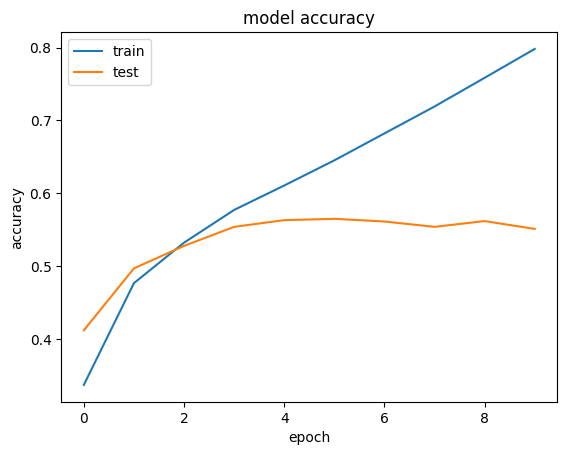

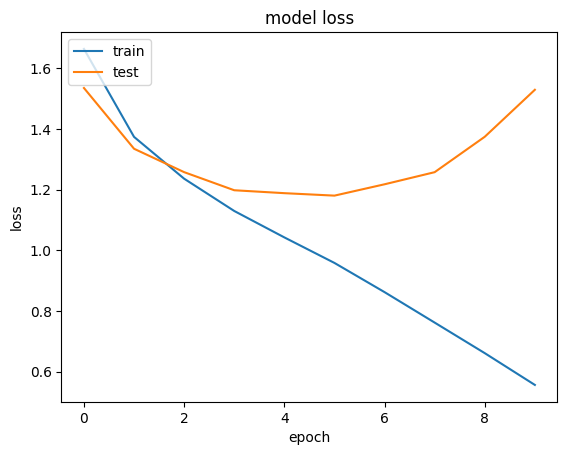

In [42]:
# prompt: training valdiation loss and accuracy plot

import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [43]:
# save model to json
model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)

In [44]:
model.save("face_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
test_image = cv2.imread("/content/images/images/validation/happy/10096.jpg",0)

In [46]:
test_image.shape

(48, 48)

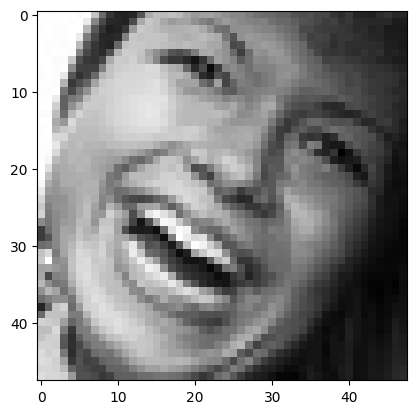

In [47]:
# prompt: google patch to visualze the image

import matplotlib.pyplot as plt

plt.imshow(test_image, cmap='gray')
plt.show()


In [48]:
test_image = test_image/255

In [49]:
test_image

array([[1.        , 0.99215686, 0.99215686, ..., 0.21568627, 0.16862745,
        0.16470588],
       [1.        , 0.99607843, 1.        , ..., 0.17647059, 0.12156863,
        0.1254902 ],
       [0.99215686, 1.        , 0.99215686, ..., 0.11764706, 0.11764706,
        0.10980392],
       ...,
       [0.86666667, 0.85098039, 0.81568627, ..., 0.11372549, 0.15294118,
        0.15294118],
       [0.83921569, 0.83921569, 0.82352941, ..., 0.12156863, 0.16470588,
        0.17254902],
       [0.87058824, 0.83921569, 0.83921569, ..., 0.13333333, 0.17254902,
        0.18823529]])

In [50]:
import numpy as np


In [51]:
test_image = np.expand_dims(test_image,axis=0)

In [52]:
test_image.shape

(1, 48, 48)

In [53]:
pred = model.predict(test_image)

1/1 [==============================] - 0s 290ms/step


In [54]:
pred

array([[4.1741267e-02, 8.5332346e-08, 6.4291563e-03, 9.5066261e-01,
        8.1674159e-05, 1.0827511e-03, 2.3865782e-06]], dtype=float32)

In [55]:
res = np.argmax(pred,axis=1)

In [56]:
res

array([3])

In [57]:
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [58]:
labels[res[0]]

'happy'